# Double Inverted Pendulum Control
## Summary
This notebook outlines state space controller design for a double inverted pendulum on a cart. For this notebook, the pendulums are of equal size and mass.

This builds on the single inverted pendulum notebook in this repository found here: `notebooks/inverted-pendulum.ipynb`

## Goals
The ultimate goal is to apply the control system to a simulated environment - for this I have chosen Python and specifially [pymunk](http://www.pymunk.org) as the 2D physics simulator and [pyglet](http://www.pyglet.org) as the game engine to render the results.

### Control System Requirements
The design criteria for this system with the cart receiving a 0.2 m step input are as follows:
* Settling time for x, Θ and α of less than 4 seconds
* Rise time for x of less than 2 seconds
* Overshoot of Θ and α of less than 20 degrees (0.35 radians)

## System Description
We will use the following diagram to derive the equations of motion (original image from Wikipedia for a single inverted pendulum, modified to have a second pendulum):

![inverted pendulum on cart](../res/img/dinvpend.png "inverted pendulum on cart")

* $\theta$ is the angle between vertical and the bottom pendulum; 0 radians when vertical and is positive in the CCW direction
* $\alpha$ (not shown in image) is the angle between vertical and the top pendulum; 0 radians when vertical and is positive in the CCW direction
* $x, y$ are the position of the cart, $y$ will be constant and considered 0
* $x1, y1$ is the bottom pendulum's position
* $x2, y2$ is the top pendulum's position
* $v1, v2, v3$ are cart and pendulums linear velocities
* $b$ is friction, and is not shown in the image, but is a force that acts against $F$ and depends on the velocity of the cart, $v1$
* $I$ is the pendulum moment of inertia
* $M, m$ are mass, in kg, of cart and pendulums respectively
* $l$ is the pendulum length
* $g$ is gravity
* $\omega_1$ and $\omega_2$ are the angular velocities of the pendulums, and equivalent to $\frac{d}{dt}\theta$ and $\frac{d}{dt}\alpha$ respectively.

### Equations of Motion
The equations of motion for this system are derived using the Lagrangian and Euler equations. This derivation references the following sources:
* [Brilliant: Lagrangian Mechanics](https://brilliant.org/wiki/lagrangian-formulation-of-mechanics/)

#### Lagrangian
The Lagrangian, L, is the difference between kinetic energy, T and potential energy V.  
$L = T - V$

In our case, we need to consider kinetic energy of the cart and pendulums (including rotational kinetic energy of both pendulums), and potential energy of the pendulums (cart is assumed to be on ground so it has no potential energy).  
$L = \frac{1}{2}Mv_{1}^2 + \frac{1}{2}mv_{2}^2 + \frac{1}{2}mv_{3}^2 + \frac{1}{2}I\omega_1^2 + \frac{1}{2}I\omega_2^2 - mgl\cos\theta - mgl(\cos\theta + \cos\alpha)$

#### Euler Equations for this system
Both x and Θ vary over time, so the Euler equations are as follows:

$\dfrac{d}{dt}\dfrac{\partial L}{\partial \dot{x}} - \dfrac{\partial L}{\partial x} = F - b\dot{x}$  

$\dfrac{d}{dt}\dfrac{\partial L}{\partial \dot{\theta}} - \dfrac{\partial L}{\partial \theta} = 0$

$\dfrac{d}{dt}\dfrac{\partial L}{\partial \dot{\alpha}} - \dfrac{\partial L}{\partial \alpha} = 0$

### derivation of equations of motion

In [1]:
import sympy
sympy.init_printing()

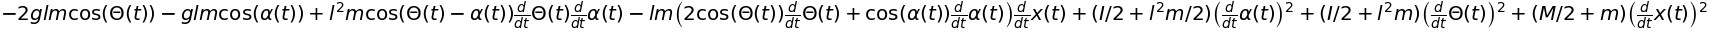

In [2]:
# create our functions for x and Θ against time, t
t = sympy.symbols('t')
x = sympy.Function('x')(t)
Θ = sympy.Function('Θ')(t)
α = sympy.Function('α')(t)

# constants: pendulum length, mass, and inertia, then cart mass, gravity, and friction
l, m, I, M, g, b = sympy.symbols('l m I M g b')

# cart position is x, y, but we can ignore y since it will be constant and zero
# cart velocity is then simply the first derivate of it's x position
v1 = x.diff(t)

# pendulum position, WRT to the cart
x2 = x - l*sympy.sin(Θ)
y2 = l*sympy.cos(Θ)

# pendulum velocity is made up of x and y velocities, found from first derivates of position
v2 = sympy.sqrt(sympy.simplify(x2.diff(t)**2 + y2.diff(t)**2))

x3 = x2 - l*sympy.sin(α)
y3 = y2 + l*sympy.cos(α)

v3 = sympy.sqrt(sympy.simplify(x3.diff(t)**2 + y3.diff(t)**2))

# kinetic energy of the system
T = sympy.Rational(1, 2)*(M*v1**2 + m*v2**2 + m*v3**2 + I*Θ.diff(t)**2 + I*α.diff(t)**2)

# potential energy of the system
V = m*g*y2 + m*g*y3

# kinetic energy of the cart, plus kinetic energy of the pendulum, subtract potential energy of pendulum and cart
L = T - V

# cleanup a bit, expand and collect on linear and angular acceleration
L = L.expand().collect((x.diff(t, t), Θ.diff(t, t), α.diff(t, t))).simplify()

# print out the Lagrangian
L

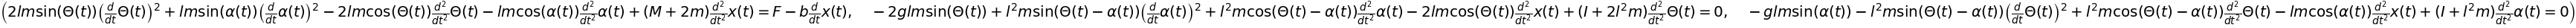

In [3]:
# euler equations
F = sympy.symbols('F')
euler1 = L.diff(x.diff(t)).diff(t) - L.diff(x)
euler2 = L.diff(Θ.diff(t)).diff(t) - L.diff(Θ)
euler3 = L.diff(α.diff(t)).diff(t) - L.diff(α)

# create the equations, first arg is LHS, second is RHS
eq1 = sympy.Eq(euler1.simplify().expand().collect(x.diff(t, t)), F - b*x.diff(t))
eq2 = sympy.Eq(euler2.simplify().expand().collect(Θ.diff(t, t)), 0)
eq3 = sympy.Eq(euler3.simplify().expand().collect(α.diff(t, t)), 0)

# print out the 3 equations
eq1, eq2, eq3

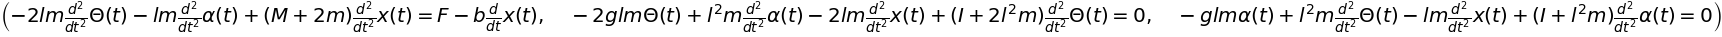

In [4]:
# linearize our system
# we want the pendulum vertical, so linearize around Θ = 0 and α = 0
# sin(Θ) = Θ, cos(Θ) = 1, (d/dt(Θ))**2 = 0
# sin(α) = α, cos(Θ) = 1, (d/dt(α))**2 = 0
# sin(Θ - α) = Θ - α, cos(Θ - α) = 1
linearize = [(sympy.sin(Θ), Θ), (sympy.cos(Θ), 1), (Θ.diff(t)**2, 0), 
             (sympy.sin(α), α), (sympy.cos(α), 1), (α.diff(t)**2, 0),
             (sympy.sin(Θ - α), Θ - α), (sympy.cos(Θ - α), 1)]
eq1_lin = eq1.subs(linearize)
eq2_lin = eq2.subs(linearize)
eq3_lin = eq3.subs(linearize)

# print out the linearized equations
eq1_lin, eq2_lin, eq3_lin

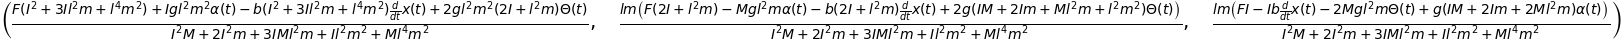

In [5]:
# solve our linear system for linear and angular acceleration
eq_of_mot = sympy.linsolve([eq1_lin, eq2_lin, eq3_lin], [x.diff(t, t), Θ.diff(t, t), α.diff(t, t)])

# get our linear and angular velocity equations
x_accel = eq_of_mot.args[0][0].expand().collect((Θ, Θ.diff(t), x, x.diff(t), α, α.diff(t), F)).simplify()
Θ_accel = eq_of_mot.args[0][1].expand().collect((Θ, Θ.diff(t), x, x.diff(t), α, α.diff(t), F)).simplify()
α_accel = eq_of_mot.args[0][2].expand().collect((Θ, Θ.diff(t), x, x.diff(t), α, α.diff(t), F)).simplify()

# print the solutions
x_accel, Θ_accel, α_accel

#### State Space Representation 
$\dot{x(t)} = Ax(t) + Bu(t)$

$y(t) = Cx(t) + Du(t)$

$\dot{x(t)} =
\begin{bmatrix}
\dot{x} \\
\ddot{x} \\
\dot{\theta} \\
\ddot{\theta} \\
\dot{\alpha} \\
\ddot{\alpha}
\end{bmatrix}
$ &nbsp;&nbsp;&nbsp;&nbsp; $x(t) =
\begin{bmatrix}
x \\
\dot{x} \\
\theta \\
\dot{\theta} \\
\alpha \\
\dot{\alpha}
\end{bmatrix}
$

let $p = I^2M + 2I^2m + 3IMl^2m + Il^2m^2 + Ml^4m^2$

$A =
\begin{bmatrix}
  0 & 1 & 0 & 0 & 0 & 0 \\
  0 & \dfrac{-b(I^2 + 3Il^2m + l^4m^2)}{p} & \dfrac{2gl^2m^2(2I + l^2m)}{p} & 0 & \dfrac{Igl^2m^2}{p} & 0  \\
  0 & 0 & 0 & 1 & 0 & 0  \\
  0 & \dfrac{-blm(2I + l^2m)}{p} & \dfrac{2glm(IM + 2Im + Ml^2m + l^2m^2)}{p} & 0 & \dfrac{-Mgl^3m^2}{p} & 0 \\
  0 & 0 & 0 & 0 & 0 & 1 \\
  0 & \dfrac{-Iblm}{p} & \dfrac{-2Mgl^3m^2}{p} & 0 & \dfrac{glm(IM + 2Im + 2Ml^2m)}{p} & 0
\end{bmatrix}
$ &nbsp;&nbsp;&nbsp;&nbsp; $B = 
 \begin{bmatrix}
  0 \\
  \dfrac{I^2 + 3Il^2m + l^4m^2}{p} \\
  0 \\
  \dfrac{lm(2I + l^2m)}{p} \\
  0 \\
  \dfrac{Ilm}{p}
 \end{bmatrix}
$ 

$C = 
 \begin{bmatrix}
  1 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 1 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 1 & 0
 \end{bmatrix}
$ &nbsp;&nbsp;&nbsp;&nbsp; $D = 
 \begin{bmatrix}
  0 \\
  0 \\
  0
 \end{bmatrix}
$

### controller design

In [6]:
# start of controller design
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.linalg
import math

In [7]:
# constants for model
constants = {
    M: 0.5,   # mass of cart
    m: 0.2,   # mass of pendulum
    b: 0.1,   # friction of cart
    l: 0.6,   # length to pendulum center of mass
    I: 0.001, # inertia of pendulum
    g: 9.81,  # gravity
}

In [8]:
# state space model
num, den = sympy.fraction(x_accel)  # pull out the denominator for A and B

A = np.matrix([
    [0, 1, 0, 0, 0, 0], 
    [0, (-b*(I**2 + 3*I*l**2*m + l**4*m**2)/den).evalf(subs=constants), (2*g*l**2*m**2*(2*I + l**2*m)/den).evalf(subs=constants), 0, (I*g*l**2*m**2/den).evalf(subs=constants), 0], 
    [0, 0, 0, 1, 0, 0], 
    [0, (-b*l*m*(2*I + l**2*m)/den).evalf(subs=constants), (2*g*l*m*(I*M + 2*I*m + M*l**2*m + l**2*m**2)/den).evalf(subs=constants), 0, (-M*g*l**3*m**2/den).evalf(subs=constants), 0],
    [0, 0, 0, 0, 0, 1],
    [0, (-I*b*l*m/den).evalf(subs=constants), (-2*M*g*l**3*m**2/den).evalf(subs=constants), 0, (g*l*m*(I*M + 2*I*m + 2*M*l**2*m)/den).evalf(subs=constants), 0]
], dtype='float64')
B = np.matrix([
    [0],
    [((I**2 + 3*I*l**2*m + l**4*m**2)/den).evalf(subs=constants)],
    [0],
    [(l*m*(2*I + l**2*m)/den).evalf(subs=constants)],
    [0],
    [(I*l*m/den).evalf(subs=constants)]
], dtype='float64')
C = np.matrix([
    [1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1, 0]
], dtype='float64')
D = np.matrix([
    [0],
    [0],
    [0]
], dtype='float64')

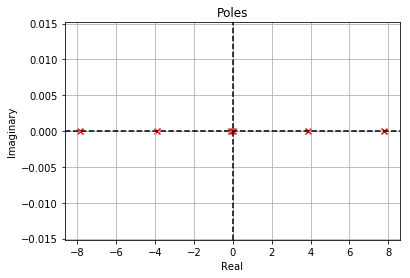

In [9]:
# plot the poles to look at open loop system stability
poles = scipy.linalg.eigvals(A)
plt.scatter([p.real for p in poles], [p.imag for p in poles], color='red', marker='x')
plt.axvline(0, color='k', linestyle='dashed')
plt.axhline(0, color='k', linestyle='dashed')
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Poles')
plt.show()

In [10]:
# system controllability - if rank[B, AB, A^2B, A^3B ...] == n, it is controllable
RM = np.concatenate([np.linalg.matrix_power(A, power) * B for power in range(A.shape[0])], axis=1)
if np.linalg.matrix_rank(RM) == A.shape[0]:
    print('System is controllable')
else:
    print('System is NOT controllable!')

System is controllable


In [11]:
# system observability - if rank [C, CA, CA^2 ...] == n, it is observable
OM = np.concatenate([C * np.linalg.matrix_power(A, power) for power in range(A.shape[0])], axis=0)
if np.linalg.matrix_rank(OM) == A.shape[0]:
    print('System is observable')
else:
    print('System is NOT observable!')

System is observable


### System Overview
System is controllable and observable, and because it has a poles in the RHS, it is unstable

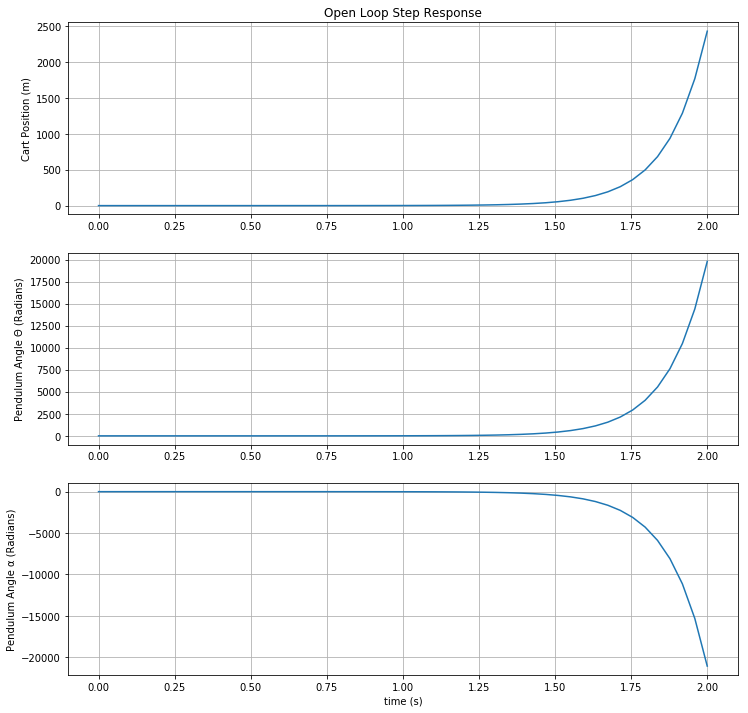

In [12]:
# system has poles in the right hand plane and looks unstable, simulate the step response with 0 initial conditions
system = scipy.signal.lti(A, B, C, D)
t = np.linspace(0, 2)
u = np.ones_like(t) * 0.2
tout, yout, xout = scipy.signal.lsim(system, u, t)

plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.plot(tout, yout[:, :1])
plt.ylabel('Cart Position (m)')
plt.title('Open Loop Step Response')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(tout, yout[:, 1:2])
plt.ylabel('Pendulum Angle Θ (Radians)')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(tout, yout[:, 2:])
plt.ylabel('Pendulum Angle α (Radians)')
plt.grid(True)

plt.xlabel('time (s)')
plt.show()

In [13]:
# define an LQR function, adapted from http://www.mwm.im/lqr-controllers-with-python/
def lqr(A, B, Q, R):
    X = np.matrix(scipy.linalg.solve_continuous_are(A, B, Q, R))
    K = np.matrix(scipy.linalg.inv(R) * (B.T * X))
    return K

In [14]:
# find structure of Q
C.T * C

matrix([[1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0.]])

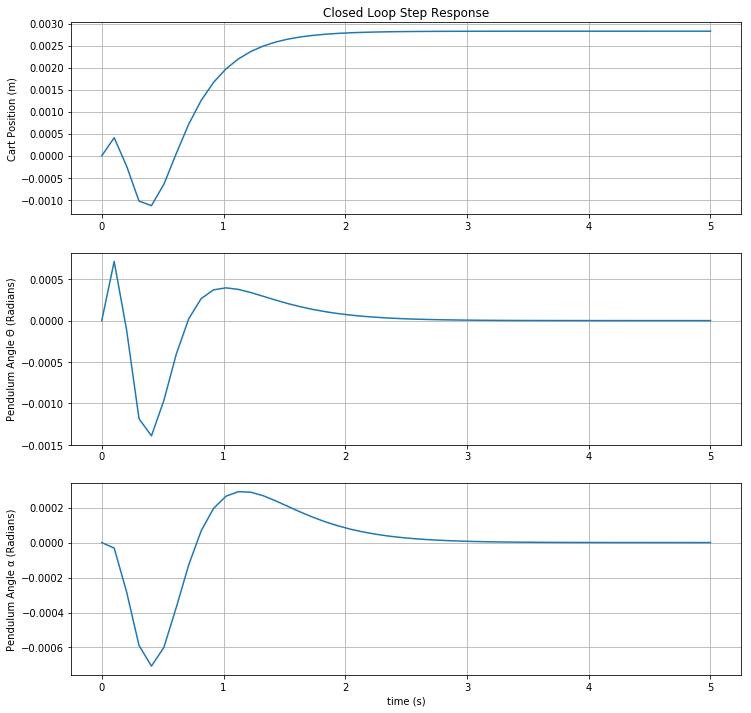

In [15]:
# element in 0,0 position used to weight cart's position, element in 2,2 position to weight pendulum angle Θ
# element in 4,4 position used to weight pendulum angle α
xg = 5000
yg = 100
zg = 100

Q = np.matrix([
    [xg, 0, 0,  0, 0,  0],
    [0,  0, 0,  0, 0,  0],
    [0,  0, yg, 0, 0,  0],
    [0,  0, 0,  0, 0,  0],
    [0,  0, 0,  0, zg, 0],
    [0,  0, 0,  0, 0,  0]
])

# R should be square have same cols as B
R = np.ones((B.shape[1], B.shape[1]))
K = lqr(A, B, Q, R)

# simulate the system with the calculated gain
Ac = A - B * K 
system = scipy.signal.lti(Ac, B, C, D)
t = np.linspace(0, 5)
u = np.ones_like(t) * 0.2
tout, yout, xout = scipy.signal.lsim(system, u, t)

plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.plot(tout, yout[:, :1])
plt.ylabel('Cart Position (m)')
plt.title('Closed Loop Step Response')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(tout, yout[:, 1:2])
plt.ylabel('Pendulum Angle Θ (Radians)')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(tout, yout[:, 2:])
plt.ylabel('Pendulum Angle α (Radians)')
plt.grid(True)

plt.xlabel('time (s)')
plt.show()

In [16]:
# adapted from: http://ctms.engin.umich.edu/CTMS/index.php?aux=Extras_rscale
def rscale(A, B, C, D, K):
    s = A.shape[0]
    Z = np.append(np.zeros((1, s)), 1)
    ABcat = np.concatenate((A, B), axis=1)
    CDcat = np.concatenate((C, D), axis=1)
    ABCDinv = np.linalg.inv(np.concatenate((ABcat, CDcat), axis=0))
    N = ABCDinv.dot(Z.T)
    Nx = N.A[0][0:s]
    Nu = N.A[0][s]
    if hasattr(K, 'gain_matrix'):
        Nbar = Nu + K.gain_matrix.dot(Nx)
    else:
        Nbar = Nu + K.dot(Nx)
    return Nbar

### What is 'rscale'?
We want to be able to provide the cart position (x-direction) as an input - the rscale function let's us map this input to something the system understands - in this case the x-direction force applied to the cart.

If you look at the above graph, we have applied a step input of 0.2 and this has resulted in a stable system (pendulum angle is at 0) but the x-position of the cart is not at 0.2.

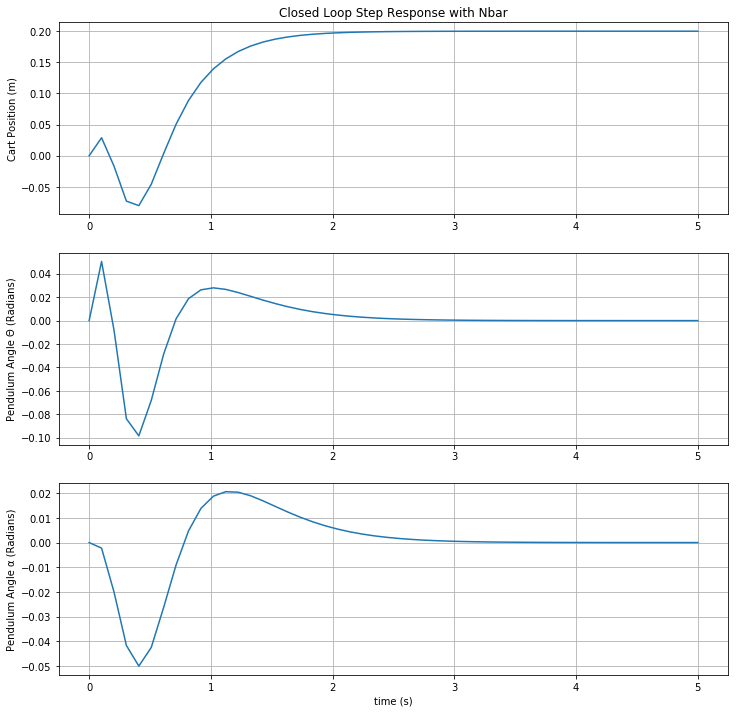

In [17]:
# let's remove steady state error - step input is 0.2m so we want the cart to reach this position
# "A different C had to be used because the rscale function will not work for multiple outputs"
Cn = C[:1]
Dn = D[:1,0]
Nbar = rscale(A, B, Cn, Dn, K)

# simulate the system with Nbar - we should see the cart position reach steady state of 0.2m
Bcn = B.dot(Nbar)
system = scipy.signal.lti(Ac, Bcn, C, D)
t = np.linspace(0, 5)
u = np.ones_like(t) * 0.2
tout, yout, xout = scipy.signal.lsim(system, u, t)

plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.plot(tout, yout[:, :1])
plt.ylabel('Cart Position (m)')
plt.title('Closed Loop Step Response with Nbar')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(tout, yout[:, 1:2])
plt.ylabel('Pendulum Angle Θ (Radians)')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(tout, yout[:, 2:])
plt.ylabel('Pendulum Angle α (Radians)')
plt.grid(True)

plt.xlabel('time (s)')
plt.show()

### System Design Results
We have now met our design requirements:
* Settling time for x, Θ and α of less than 4 seconds
* Rise time for x of less than 2 seconds
* Overshoot of Θ and α of less than 20 degrees (0.35 radians)

### Digital Controller Design
Because our physics simulation is in discrete time, we need to convert our system to discrete time and perform similar steps. We will be sampling the states 60 times per second in the simulation.

In [18]:
# let's convert the system into discrete time, so we can simulate with pymunk physics engine and pyglet game engine
# we'll sample state 60 times per second
ts = 1.0/60.0
F, G, H, J, dt = scipy.signal.cont2discrete((A, B, C, D), ts)
dsystem = (F, G, H, J, dt)

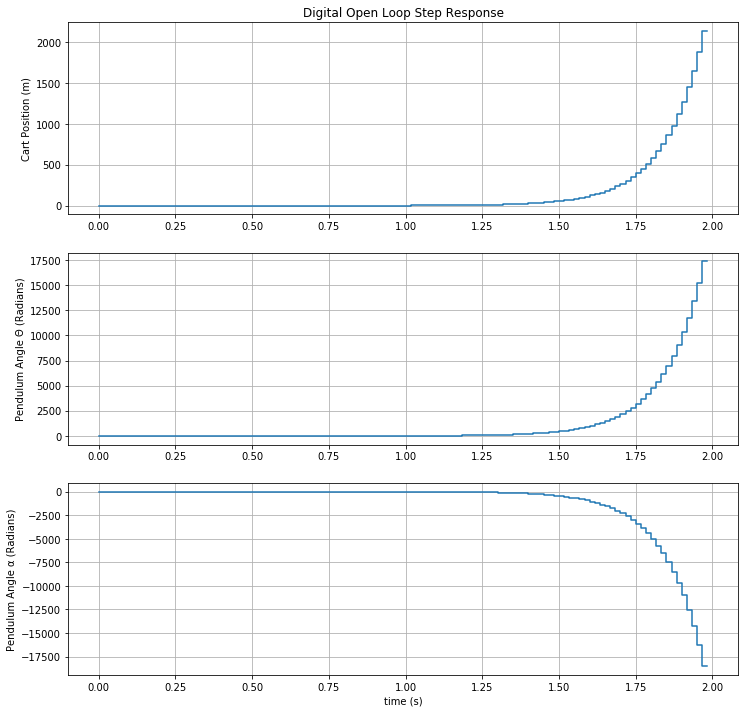

In [19]:
# test the open loop system against a step input
system = scipy.signal.dlti(F, G, H, J)
tsim = 2
samples = math.ceil(tsim / ts)
t = np.linspace(0, tsim, samples)
u = np.ones_like(t) * 0.2
tout, yout, xout = scipy.signal.dlsim(system, u)

plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.step(tout * dt, yout[:, :1])
plt.ylabel('Cart Position (m)')
plt.title('Digital Open Loop Step Response')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.step(tout * dt, yout[:, 1:2])
plt.ylabel('Pendulum Angle Θ (Radians)')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.step(tout * dt, yout[:, 2:])
plt.ylabel('Pendulum Angle α (Radians)')
plt.grid(True)

plt.xlabel('time (s)')
plt.show()

In [20]:
# define an discrete time LQR function - created using the following reference:
# https://en.wikipedia.org/wiki/Linear%E2%80%93quadratic_regulator
def dlqr(A, B, Q, R):
    P = np.matrix(scipy.linalg.solve_discrete_are(A, B, Q, R))
    K = np.matrix(scipy.linalg.inv(R + B.T * P * B) * (B.T * P * A))
    return K

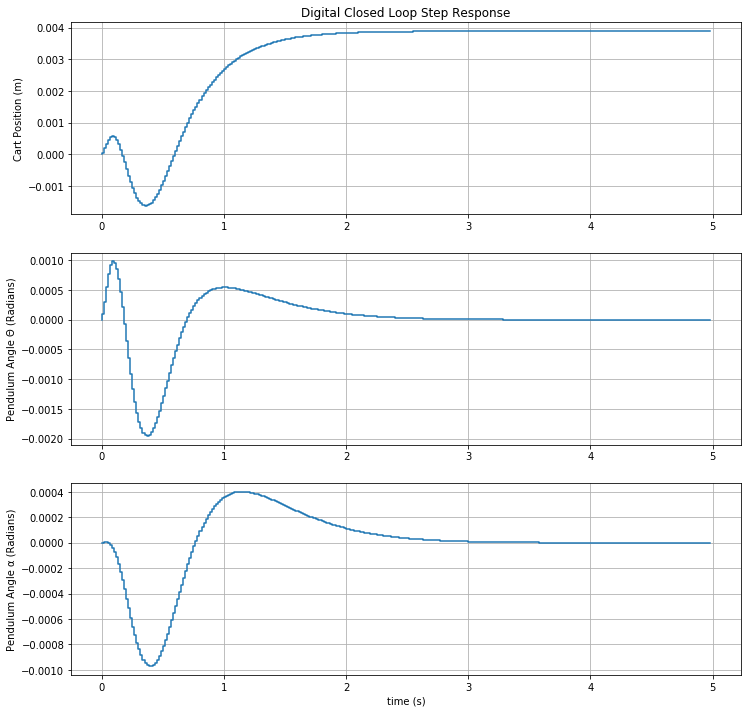

In [21]:
# design digital LQR controller - using same gains as before
Qd = np.matrix([
    [xg, 0, 0,  0, 0,  0],
    [0,  0, 0,  0, 0,  0],
    [0,  0, yg, 0, 0,  0],
    [0,  0, 0,  0, 0,  0],
    [0,  0, 0,  0, zg, 0],
    [0,  0, 0,  0, 0,  0]
])

# R should be square have same cols as B
R = np.ones((B.shape[1], B.shape[1]))
Kd = dlqr(F, G, Qd, R)

# simulate the system with the calculated gain
Fc = F - G * Kd
system = scipy.signal.dlti(Fc, G, H, J)
tsim = 5
samples = math.ceil(tsim / ts)
t = np.linspace(0, tsim, samples)
u = np.ones_like(t) * 0.2
tout, yout, xout = scipy.signal.dlsim(system, u)

plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.step(tout * dt, yout[:, :1])
plt.ylabel('Cart Position (m)')
plt.title('Digital Closed Loop Step Response')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.step(tout * dt, yout[:, 1:2])
plt.ylabel('Pendulum Angle Θ (Radians)')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.step(tout * dt, yout[:, 2:])
plt.ylabel('Pendulum Angle α (Radians)')
plt.grid(True)

plt.xlabel('time (s)')
plt.show()

In [22]:
Nbar

matrix([[70.71067812]])

### Digital Nbar
We can't use the original rscale function because it is for a continuous time (CT) system, but we can use the CT Nbar value as a starting point and manually tweak it to get our steady state to the desired 0.2 m output.

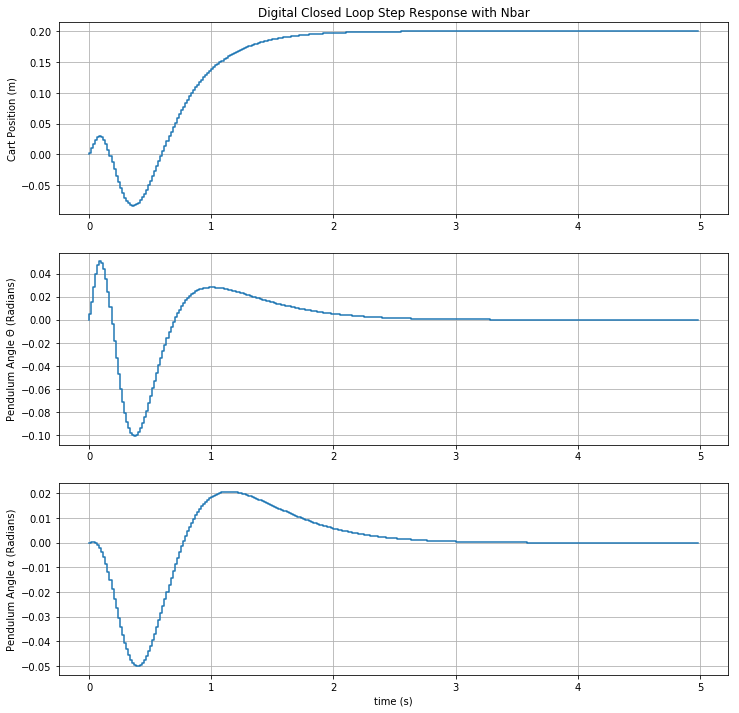

In [23]:
# let's remove steady state error - step input is 0.2 m so we want the cart to reach this position
# we can't use rscale since it was for continuous time (CT) systems, but we can use CT Nbar as a starting point 
# and tweak it
# using trial and error - started with Nbar value
Nbard = np.matrix([[51.5]])

# simulate the system with Nbar - we should see the cart position reach steady state of 0.2 m if Nbard is set 
# appropriately
Gcn = G * Nbard
system = scipy.signal.dlti(Fc, Gcn, H, J)
tsim = 5
samples = math.ceil(tsim / ts)
t = np.linspace(0, tsim, samples)
u = np.ones_like(t) * 0.2
tout, yout, xout = scipy.signal.dlsim(system, u)

plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.step(tout * dt, yout[:, :1])
plt.ylabel('Cart Position (m)')
plt.title('Digital Closed Loop Step Response with Nbar')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.step(tout * dt, yout[:, 1:2])
plt.ylabel('Pendulum Angle Θ (Radians)')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.step(tout * dt, yout[:, 2:])
plt.ylabel('Pendulum Angle α (Radians)')
plt.grid(True)

plt.xlabel('time (s)')
plt.show()

In [24]:
# dump out our gain matrix so we can use it in our simulation
Kd

matrix([[  51.43763708,   54.12690472,  157.5467596 ,  -21.67111679,
         -429.11603909,  -88.73125241]])

### Applying this to Code
We can derive the function for our input (u) using the following diagram of the system:  
![State Feedback with Precompensation](http://ctms.engin.umich.edu/CTMS/Content/InvertedPendulum/Control/StateSpace/figures/statefeedback_w_pre_pend.png "State Feedback with Precompensation")  

$\vec{u} = \vec{r}N - K\vec{x}$

Where $\vec{r}$ is our desired results (just the x-position of the cart in this case), N is our digital Nbar matrix (a 1x1 matrix in this case), K is our digital gain matrix, and $\vec{x}$ is the state vector. 

There are 6 values in the gain matrix K that correspond to the 4 states we are measuring: 
* cart x-position
* cart x-velocity
* bottom pendulum angle from vertical
* bottom pendulum angular velocity
* top pendulum angle from vertical
* top pendulum angular velocity

The input vector $\vec{u}$ in this case only has the x-direciton force to apply to the cart.

In practice, the code will look something like this:

```python
# this code would sit in some periodic loop (at our sampling rate, which in this case is 60 times per second)

# constants - gain matrix and Nbar
K = [51.43763708, 54.12690472, 157.5467596, -21.67111679, -429.11603909, -88.73125241]
Nbar = 51.5

# the following states would be sampled
# posx is cart position (x-direction)
# velx is cart velocity (x-direction)
# theta is bottom pendulum angle
# thetav is bottom pendulum angular velocity
# alpha is top pendulum angle
# alphav is top pendulum angular velocity

# calculate the gain based on the current state
gain = K[0] * posx + K[1] * velx + K[2] * theta + K[3] * thetav + K[4] * alpha + K[5] * alphav

# calculate the required force (u)
# ref is our desired x-position of the cart - in our examples this was 0.2 m
force = ref * NBAR - gain

# we can now apply this force to the cart center of mass (in the x-direction)
```

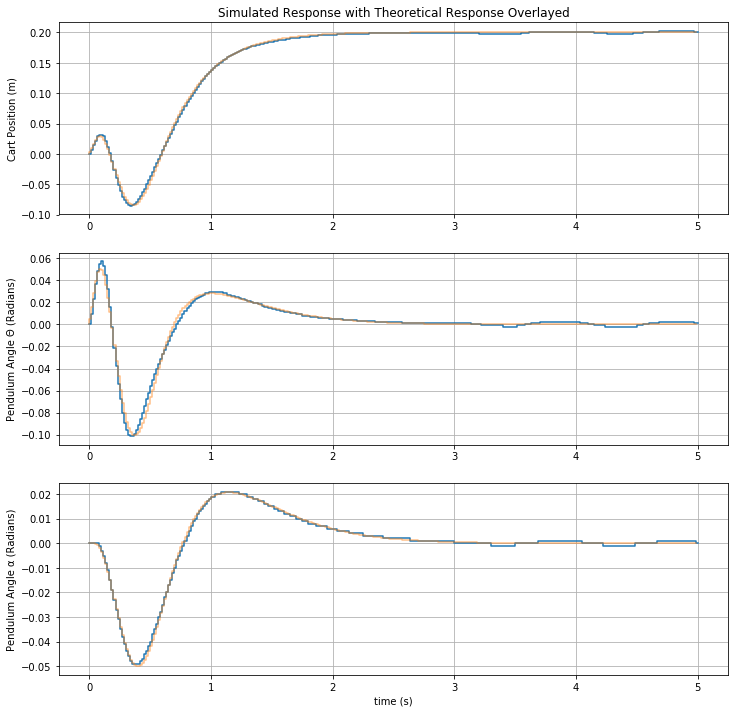

In [25]:
# plot results from simulation run in pyglet/pymunk
import csv

t, x, theta, alpha = [], [], [], []
with open('../data/dinvpend.csv', 'r') as f:
    for row in csv.reader(f):
        t.append(row[0])
        x.append(row[1])
        theta.append(row[2])
        alpha.append(row[3])

# ignore first row (labels) and convert data to floats
t = [float(a) for a in t[1:]]
x = [float(a) for a in x[1:]]
theta = [float(a) for a in theta[1:]]
alpha = [float(a) for a in alpha[1:]]

plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.step(t, x)
plt.step(tout * dt, yout[:, :1], alpha=0.5)
plt.ylabel('Cart Position (m)')
plt.title('Simulated Response with Theoretical Response Overlayed')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.step(t, theta)
plt.step(tout * dt, yout[:, 1:2], alpha=0.5)
plt.ylabel('Pendulum Angle Θ (Radians)')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.step(t, alpha)
plt.step(tout * dt, yout[:, 2:], alpha=0.5)
plt.ylabel('Pendulum Angle α (Radians)')
plt.grid(True)

plt.xlabel('time (s)')
plt.show()